In [1]:
from scipy.stats import norm

import numpy as np
from math import cos, sin

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from copy import copy
from sklearn.decomposition import PCA

/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# 7.1  The Curse of Dimensionality

Consider a D-dimensional uniform distribution with coordinates between [r,-r] on each axis. 
What is the probability of randomly drawing a point that lies within a distance $ r=\sqrt{x_1^2+\dots+x_{D}^2} $ of the origin? 

The volume of a hypersphere with radius r is $$ V_D(r)=\frac{2 r^D \pi^{D/2}}{D~\Gamma(D/2)} $$ so this probability is given by $$ f_D=\frac{V_D(r)}{(2r)^D} = \frac{\pi^{D/2}}{D~2^{D-1}~\Gamma(D/2)} $$ The limit of which goes to zero as D approaches infinity: $$  \lim_   {D\to \infty} f_d = 0 $$

The larger the dimensionality of your data set, the more difficult it is to evenly sample its volume. 
 

# 7.3 Principal Component Analysis
### Simple explanation:
#### PCA is a method for reducing the dimensionality of a data set while preserving as much of the valuable information in that set as possible.
#### Some reasons why PCA is useful:
- By reducing the dimensionality of our data, we can more easily visualize it (e.g., 3D->2D transformation)
- It reduces the amount of space needed to store the data
- It can speed up computation time in working with the data (less things to calculate)
- It can give us useful insights into the way our data's features relate to one another

#### The PCA algorithm essentially performs the following steps:
1. Given a set of data $\vec{x}$ in $k$-dimensions aligned with axes $\hat{e}_{i}$, find a new set of $k$ axes $\hat{e}_{i}'$ such that the covariances of the data set with respect to the new axes is zero: $\sigma_{\hat{e}_{i}'}\sigma_{\hat{e}_{j}'} = 0 \text{ for all } i\neq j$.
2. Drop the axes with the least variances

#### A very informative link:
http://setosa.io/ev/principal-component-analysis/

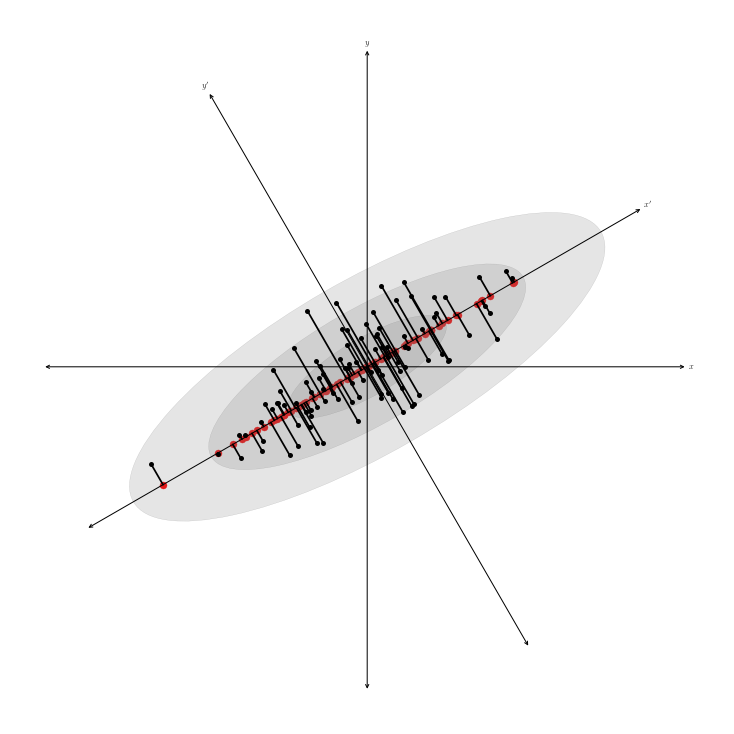

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Set parameters and draw the random sample
np.random.seed(42)
r = 0.9

sigma1 = 0.25
sigma2 = 0.08
rotation = np.pi / 6
s = np.sin(rotation)
c = np.cos(rotation)

X = np.random.normal(0, [sigma1, sigma2], size=(100, 2)).T
R = np.array([[c, -s],
              [s, c]])
X = np.dot(R, X)

#------------------------------------------------------------
# Plot the diagram
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = plt.axes((0, 0, 1, 1), xticks=[], yticks=[], frameon=False)

# draw axes
ax.annotate(r'$x$', (-r, 0), (r, 0),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', color='k', lw=1))
ax.annotate(r'$y$', (0, -r), (0, r),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', color='k', lw=1))

# draw rotated axes
ax.annotate(r'$x^\prime$', (-r * c, -r * s), (r * c, r * s),
            ha='center', va='center',
            arrowprops=dict(color='k', arrowstyle='<->', lw=1))
ax.annotate(r'$y^\prime$', (r * s, -r * c), (-r * s, r * c),
            ha='center', va='center',
            arrowprops=dict(color='k', arrowstyle='<->', lw=1))

# scatter points
ax.scatter(X[0], X[1], s=25, lw=0, c='k', zorder=2)

# draw lines
vnorm = np.array([s, -c])
for v in (X.T):
    d = np.dot(v, vnorm)
    v1 = v - d * vnorm
    ax.plot([v[0], v1[0]], [v[1], v1[1]], '-k')
    ax.scatter(v1[0], v1[1], color = (1,0,0), s = 50)

# draw ellipses
for sigma in (1, 2, 3):
    ax.add_patch(Ellipse((0, 0), 2 * sigma * sigma1, 2 * sigma * sigma2,
                         rotation * 180. / np.pi,
                         ec='k', fc='gray', alpha=0.2, zorder=1))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)


plt.show()

## 7.3.1 Derivation of Principal Component Analysis (page 293)

- Start with a set of data $\boldsymbol{X}$ comprising a series of $N$ observations (e.g., stars), each observation made up of $K$ features (e.g. magnitude, color, etc.). $X^{\left(j\right)}_{i}$ is feature $j$ of the $i^{\text{th}}$ observation.


- Subtract the mean of each feature from every data point: $X^{\left(j\right)}_{i}\rightarrow X^{\left(j\right)}_{i}-\bar{X}^{\left(j\right)}$
    - Optionally, one can scale all features by dividing data by the feature standard deviation

- Calculate the variance of the data along some arbitrary axis $\hat{r}_{1}$:
$$\begin{align}
\sigma_{\hat{r}_{1}}^{2} &= \sum_{i}^{N}\left(\vec{X_{i}}\cdot\hat{r}_{1}\right)^{2}\\
&=\sum_{i}^{N}\left(\hat{r}_{1}^{T}\cdot\vec{X_{i}}^{T}\right)\left(\vec{X_{i}}\cdot\hat{r}_{1}\right)\\
\end{align}
$$

- Choose $\hat{r}_{1}$ to be the axis of maximum variance. To find $\hat{r}_{1}$, maximize the variance subject to the constraint $\hat{r}_{1}^{T}\hat{r}_{1} = 1$ (the axis is a unit vector); this can be done by using Lagrange multipliers:

$$\phi\left(\hat{r}_{1},\lambda_{1}\right)=\
\sum_{i}^{N}\left(\hat{r}_{1}^{T}\cdot\vec{X_{i}}^{T}\right)\left(\vec{X_{i}}\cdot\hat{r}_{1}\right)\
-\lambda_{1}\left(\hat{r}_{1}^{T}\hat{r}_{1}-1\right)$$

- Setting $\frac{\text{d}\phi}{\text{d}\hat{r}_{1}} = 0$ yields

$$\left(\sum_{i}^{N}\vec{X}_{i}^{T}\vec{X}_{i}\right)\hat{r}_{1}-\lambda_{1}\hat{r}_{1}=0$$

- This is an eigenvalue equation for the maximum variance $\lambda_{1}$ and the corresponding axis of maximal variance $\hat{r}_{1}$.

- Notice that $\sum_{i}^{N}\vec{X}_{i}^{T}\vec{X}_{i} = \boldsymbol{X}^{T}\boldsymbol{X}=\boldsymbol{C}_{\boldsymbol{X}}$--the axis of maximum variance is an eigenvector of the covariance matrix

- To get the next axis $\hat{r}_{2}$, we solve the same Lagrange multiplier equation with the additional constraint that the covariance $\sigma_{\hat{r}_{1}\hat{r}_{2}} = 0$, and repeat

- Finally, we transform the data by taking $\boldsymbol{Y}=\boldsymbol{X}\boldsymbol{R}$ and dropping low-variance features (the right-most rows in the transformed data







### Singular value decomposition (SVD)

- The PCA can be computed through the data matrix $\boldsymbol{X}$ itself rather than through the eigenvalue decomposition of the covariance matrix; this method is known as **singular value decomposition**

- SVD: 
$$\boldsymbol{U\Sigma V}^{T}=\frac{1}{\sqrt{N-1}}\boldsymbol{X}$$

- $\boldsymbol{U}$: *left-singular matrix*
- $\boldsymbol{\Sigma}$: matrix of singular values
- $\boldsymbol{V}$: *right-singular matrix*

$$\boldsymbol{C}_{\boldsymbol{X}}=\left[\frac{1}{\sqrt{N-1}}\right]$$

- Can show that
    - $\boldsymbol{V}=\boldsymbol{R}$
    - $\boldsymbol{\Sigma}^{2}=\boldsymbol{C}_{\boldsymbol{Y}}$
- SVD of the data directly yields the projection $\boldsymbol{R}$ and variances $\boldsymbol{C}_{\boldsymbol{Y}}$

### Three ways to calculate the principal components $\boldsymbol{R}$ and the eigenvalues $\boldsymbol{C}_{\boldsymbol{Y}}$: 
1. Eigenvalue decomposition of covariance matrix $\boldsymbol{C}_{\boldsymbol{X}}$
    - Use if $N\gg K$
2. SVD of $\boldsymbol{X}$
    - Use if $N\sim K$
3. Eigenvalue decomposition of correlation matrix $\boldsymbol{M}_{\boldsymbol{X}}$
    - Use if $K\gg N$


## 7.3.2 The Application of PCA

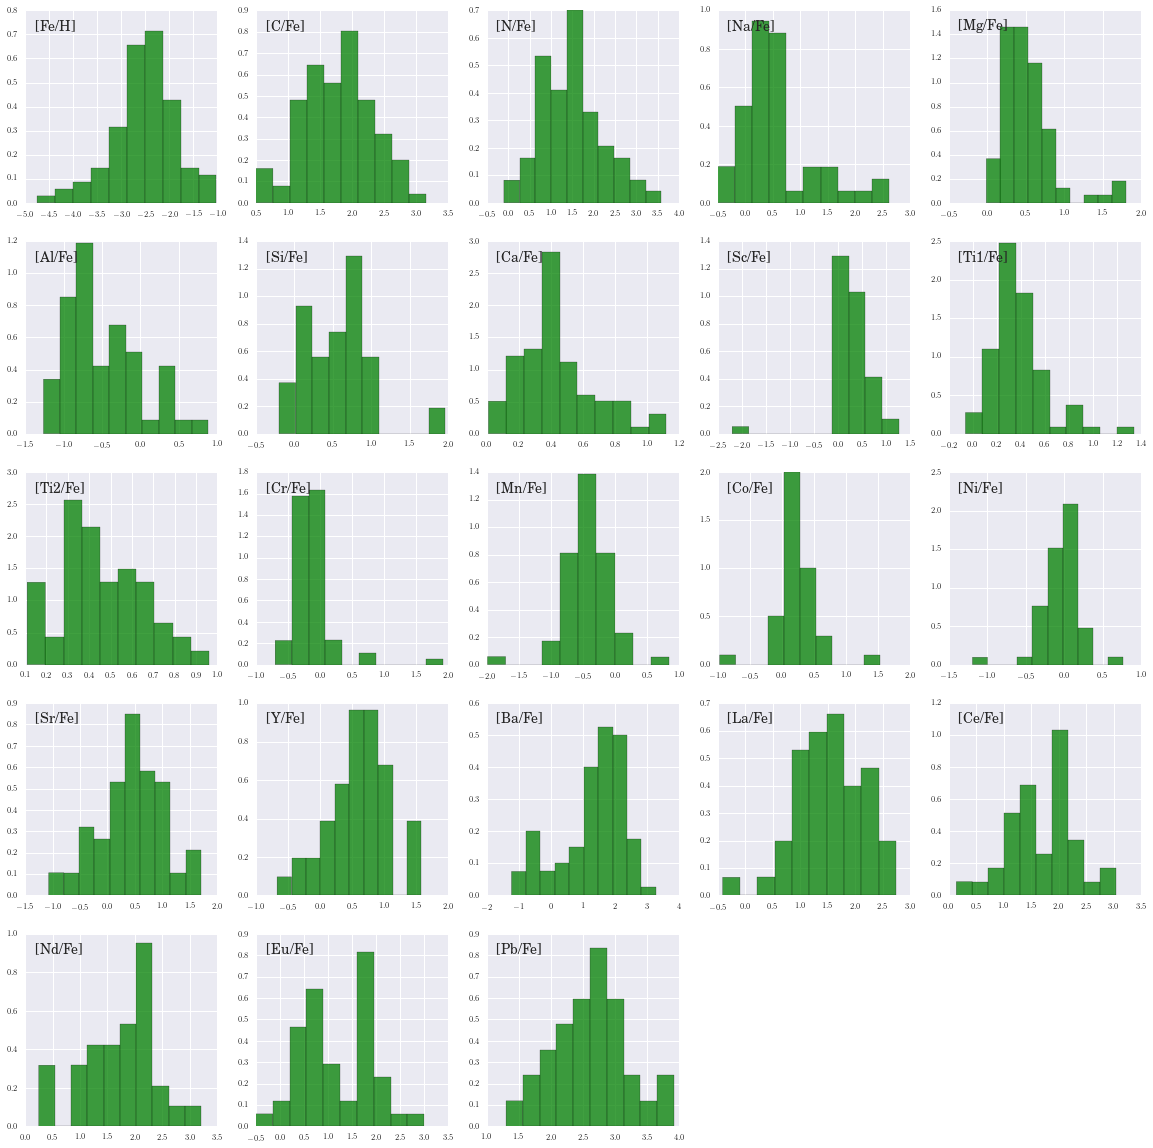

In [3]:
#We have ~100 carbon enhanced metal poor stars with 23 chemical abundances measured [Fe/H] and [X/Fe]

#importing and floatify data
infile=open('CEMPabundances.dat','r')
per_row = []
for line in infile:
    per_row.append(line.split('\t'))
elem_abundance_arr_str = zip(*per_row)

truncated_elem_abundance_arr=[]
tot_elem_abundance_arr=[]
for arr0 in elem_abundance_arr_str:
    tot_elem_abundance_arr.append([float(i) for i in arr0])

#remove unmeasured elements
for n in range(len(tot_elem_abundance_arr)):
    arr0=tot_elem_abundance_arr[n]
    truncated_elem_abundance_arr.append([x for x in arr0 if x!=-10000.])
#read labels for abundances
infile.close()
#for arr in elem_abundance_arr:
#    for i in range(len(arr)):
#        arr[i]=float(arr[i])
infile=open('elem_list.dat','r')
per_row = []
for line in infile:
    per_row.append(line.split('\t'))
elems=per_row[0]
infile.close()

#histogram distributions in abundances
fig = plt.figure(figsize=(20, 20))
for n in range(0,23):
    ax=fig.add_subplot(5,5,(n+1))
    ax.hist(truncated_elem_abundance_arr[n], 10, normed=1, facecolor='green', alpha=0.75)
    #ax.set_xlabel(elems[n])
    ax.annotate(elems[n] ,xy=(0.05,0.9), xycoords='axes fraction', size=14)

plt.show()

# searching for structure in a 23-dimensional data set

Without reducing the dimensionality, we can play around and try to search for some structure in the abundances. Looking for correlations between two dimensions is doable. If we were looking for structure in a plane defined by just two of these axes, we could make a triangle plot (no room here though) and visually inspect for any pairs of related abundances. We could do something similar to search for structure in the data that depended on 3 dimensions, but that would be hard to visualize and we'd have $\mathcal{O}(D^3)$ combinations to test. 

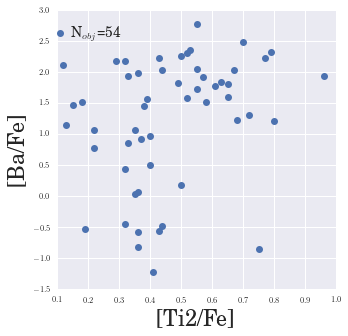

In [4]:
Dim1=10  #0-22    cheat: try combinations of 1,17,18,20,21,22
Dim2=17  #0-22

Nobjs=len(tot_elem_abundance_arr[0])

#reform this array since next cell is changing it for whatever reason
tot_elem_abundance_arr=[]
for arr0 in elem_abundance_arr_str:
    tot_elem_abundance_arr.append([float(i) for i in arr0])

#only use objects with measurements for both elements
arr1,arr2=[],[]
for obj in range(Nobjs):
    if tot_elem_abundance_arr[Dim1][obj]!=-10000. and tot_elem_abundance_arr[Dim2][obj]!=-10000.:
        arr1.append(tot_elem_abundance_arr[Dim1][obj])
        arr2.append(tot_elem_abundance_arr[Dim2][obj])

fig=plt.figure(figsize=(5, 5))
ax=fig.add_subplot(111)

ax.plot(arr1,arr2, 'o')
ax.annotate('N$_{obj}$='+repr(len(arr1)) ,xy=(0.05,0.9), xycoords='axes fraction', size=14)
ax.set_xlabel(elems[Dim1],fontsize=22)
ax.set_ylabel(elems[Dim2],fontsize=22)

# use PCA to find vectors in 23-space that account for most variance

Percent of variance in each PC
[ 0.30142724  0.19391847  0.10661034]


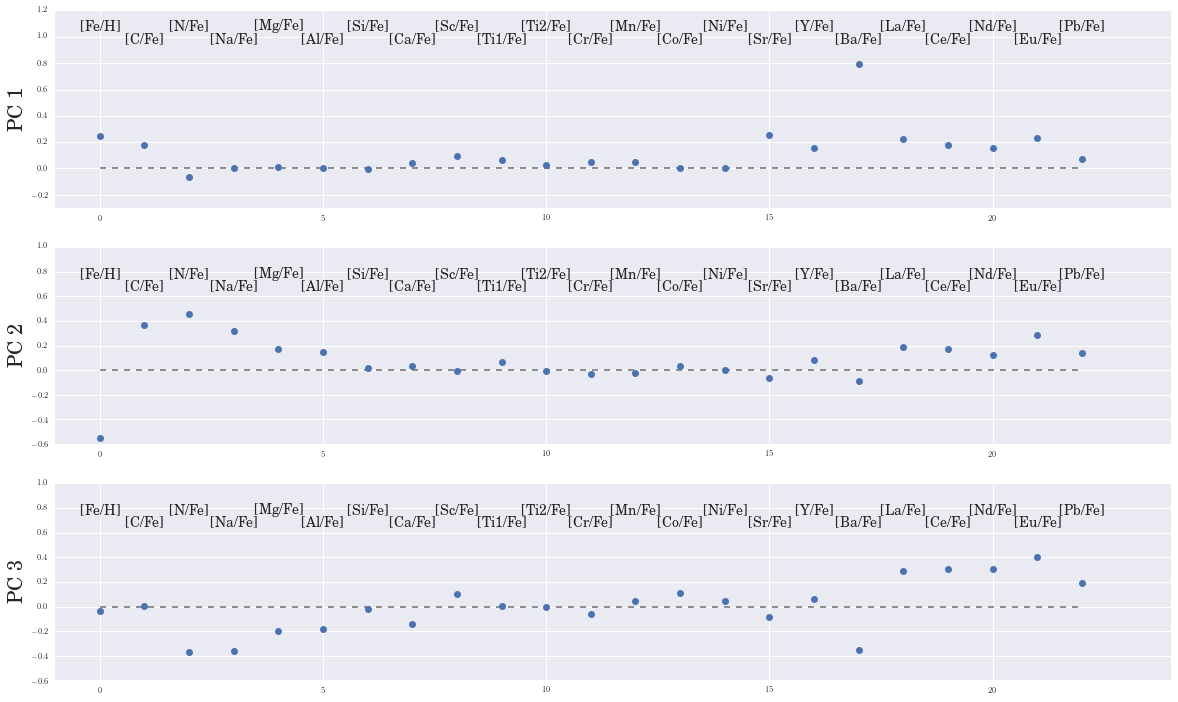

In [5]:
#unmeasured elements replaced with median of measurements
processed_arr=[]    
copy_arr=list(copy(tot_elem_abundance_arr))

for n in range(len(copy_arr)):
    arr=copy_arr[n]
    processed_arr.append(arr)
    temp_arr=[]
    for i in range(Nobjs):
        if arr[i]!=-10000:
            temp_arr.append(arr[i])
    for i in range(Nobjs):
        if arr[i]==-10000:
            processed_arr[n][i]=np.median(temp_arr)
processed_arr=np.transpose(processed_arr)
            
pca = PCA(n_components=3)

pca.fit(processed_arr)

print 'Percent of variance in each PC'
print(pca.explained_variance_ratio_) 

pca_score = pca.explained_variance_ratio_
V = pca.components_
PC1, PC2, PC3=V[0],V[1],V[2]


# plot orientations of principal components
fig=plt.figure(figsize=(20, 12))
ax=fig.add_subplot(311)

x=np.linspace(0,22,23)
zeroline=np.zeros(23)
ax.set_xlim([-1,24])
ax.set_ylim([-0.3,1.2])
ax.set_ylabel('PC 1',fontsize=20)
ax.plot(x,zeroline,'--',color='grey')

for n in range(len(elems)):
    ax.annotate(elems[n] ,xy=(n,1.0+((-1)**n)*0.05), xycoords='data',ha="center", size=14)
ax.plot(x,PC1,'o')

ax2=fig.add_subplot(312)
ax2.set_xlim([-1,24])
ax2.set_ylim([-0.6,1.0])
ax2.set_ylabel('PC 2',fontsize=20)
ax2.plot(x,zeroline,'--',color='grey')

for n in range(len(elems)):
    ax2.annotate(elems[n] ,xy=(n,0.7+((-1)**n)*0.05), xycoords='data',ha="center", size=14)
ax2.plot(x,PC2,'o')

ax3=fig.add_subplot(313)
ax3.set_xlim([-1,24])
ax3.set_ylim([-0.6,1.0])
ax3.set_ylabel('PC 3',fontsize=20)
ax3.plot(x,zeroline,'--',color='grey')

for n in range(len(elems)):
    ax3.annotate(elems[n] ,xy=(n,0.7+((-1)**n)*0.05), xycoords='data',ha="center", size=14)
ax3.plot(x,PC3,'o')


In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML import datasets

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# load data:
data = datasets.fetch_sdss_corrected_spectra()
spectra = datasets.sdss_corrected_spectra.reconstruct_spectra(data)

# Eigenvalues can be computed using PCA as in the commented code below:

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(spectra)
#evals = pca.explained_variance_ratio_
#evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]

#------------------------------------------------------------
# plot the eigenvalues
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='k')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='k')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
ax.set_ylim(0.65, 1.00)

plt.show()

![Alt text](./fig_eigenvalues_1.png)

In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:

#from sklearn.decomposition import PCA
#pca = PCA()
#pca.fit(spectra)
#evals = pca.explained_variance_ratio_
#evals_cs = evals.cumsum()

#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

![Alt text](./fig_spec_reconstruction_1.png)

### Reconstruction of data from the eigenbasis:

$$\vec{x}_{i}\left(k\right)=\vec{\mu}\left(k\right)+\sum_{j}^{R}\theta_{ij}\vec{e}_{j}\left(k\right)$$

$$\theta_{ij}=\sum_{k}\vec{e}_{j}\left(k\right)\left(\vec{x}_{i}\left(k\right)-\vec{\mu}\left(k\right)\right)$$

- Truncate the expansion to compress the data:
$\vec{x}_{i}\left(k\right)=\sum_{i}^{r<R}\theta_{i}\vec{e}_{i}\left(k\right)$

- How many terms to include in the expansion? One way is to define a bound $\alpha$ on the fraction of the variance we want to capture:

$$\frac{\sum_{i}^{i=r}\sigma_{i}}{\sum_{i}^{i=R}\sigma_{i}}<\alpha$$

- $\alpha$ typically taken from 0.70 to 0.95;

- Manually inspect the cumulative-eigenvalues plot, truncate at the 'knee'

## PCA with missing data

In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.datasets import sdss_corrected_spectra

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get spectra and eigenvectors used to reconstruct them
data = fetch_sdss_corrected_spectra()
spec = sdss_corrected_spectra.reconstruct_spectra(data)
lam = sdss_corrected_spectra.compute_wavelengths(data)
evecs = data['evecs']
mu = data['mu']
norms = data['norms']
mask = data['mask']

#------------------------------------------------------------
# plot the results
i_plot = ((lam > 5750) & (lam < 6350))
lam = lam[i_plot]

specnums = [20, 8, 9]
subplots = [311, 312, 313]

fig = plt.figure(figsize=(5, 6.25))
fig.subplots_adjust(left=0.09, bottom=0.08, hspace=0, right=0.92, top=0.95)

for subplot, i in zip(subplots, specnums):
    ax = fig.add_subplot(subplot)

    # compute eigen-coefficients
    spec_i_centered = spec[i] / norms[i] - mu
    coeffs = np.dot(spec_i_centered, evecs.T)

    # blank out masked regions
    spec_i = spec[i]
    mask_i = mask[i]
    spec_i[mask_i] = np.nan

    # plot the raw masked spectrum
    ax.plot(lam, spec_i[i_plot], '-', color='k',
            label='True spectrum', lw=1.5)

    # plot two levels of reconstruction
    for nev in [10]:
        if nev == 0:
            label = 'mean'
        else:
            label = 'reconstruction\n(nev=%i)' % nev
        spec_i_recons = norms[i] * (mu + np.dot(coeffs[:nev], evecs[:nev]))
        ax.plot(lam, spec_i_recons[i_plot], label=label, color='grey')

    # plot shaded background in masked region
    ylim = ax.get_ylim()
    mask_shade = ylim[0] + mask[i][i_plot].astype(float) * ylim[1]
    plt.fill(np.concatenate([lam[:1], lam, lam[-1:]]),
             np.concatenate([[ylim[0]], mask_shade, [ylim[0]]]),
             lw=0, fc='k', alpha=0.2)

    ax.set_xlim(lam[0], lam[-1])
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    if subplot == 311:
        ax.legend(loc=1)

    ax.set_xlabel('$\lambda\ (\AA)$')
    ax.set_ylabel('normalized flux')

plt.show()

![Alt text](./fig_PCA_reconstruction_1.png)